In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
%matplotlib inline

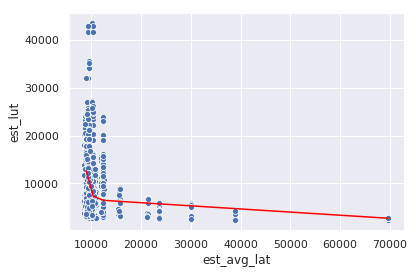

In [122]:
df = pd.read_csv('data/summary.csv')
# df = df[df.unroll.isin(range(10, 17))].reset_index()
dahlia_accepted = pd.read_csv('data/accepted.txt')
# idxs = df.apply(lambda row: row.unroll % row.bank1 == 0 and row.unroll % row.bank2 == 0 and row.resource1 == 'RAM_T2P_BRAM' and row.resource2 == 'RAM_T2P_BRAM', axis=1)
# small_df = df.loc[idxs].sort_values(by=['unroll', 'bank1', 'bank2'])[['bench', 'unroll', 'bank1', 'bank2', 'est_max_lat', 'est_lut', 'est_dsp']]
# small_df['lat/lut'] = df.apply(lambda row: row.est_max_lat / row.est_lut, axis=1)
# m = small_df['lat/lut'].min()
# small_df['lat/lut'] -= m
# small_df.sort_values(by='lat/lut')
# small_df.to_csv('comp.csv')
# small_df


#lr = LinearRegression()  
#X = df.est_avg_lat.values.reshape(-1, 1)  # values converts it into a numpy array
#Y = df.est_lut.values.reshape(-1, 1)
#lr.fit(X, Y)
#Y_pred = lr.predict(X)
#plt.figure()
#sns.scatterplot(X.reshape(-1), Y.reshape(-1))
#sns.lineplot(X.reshape(-1), Y_pred.reshape(-1), color='red')
# X.reshape(4608)

In [4]:
# Make sure estimated latencies are consistent
for idx in range(len(df)):
    assert df.est_min_lat[idx] == df.est_max_lat[idx] and df.est_max_lat[idx] == df.est_avg_lat[idx]

# Cleanup bench names
df.bench = df.apply(lambda row: row.bench.replace('test:dot-product-', ''), axis=1)
dahlia_accepted = dahlia_accepted.apply(lambda row: row.bench.replace('./dahlia-dot-product-', ''), axis=1)

In [5]:
dahlia_points = df[df["bench"].isin(dahlia_accepted.to_numpy())]

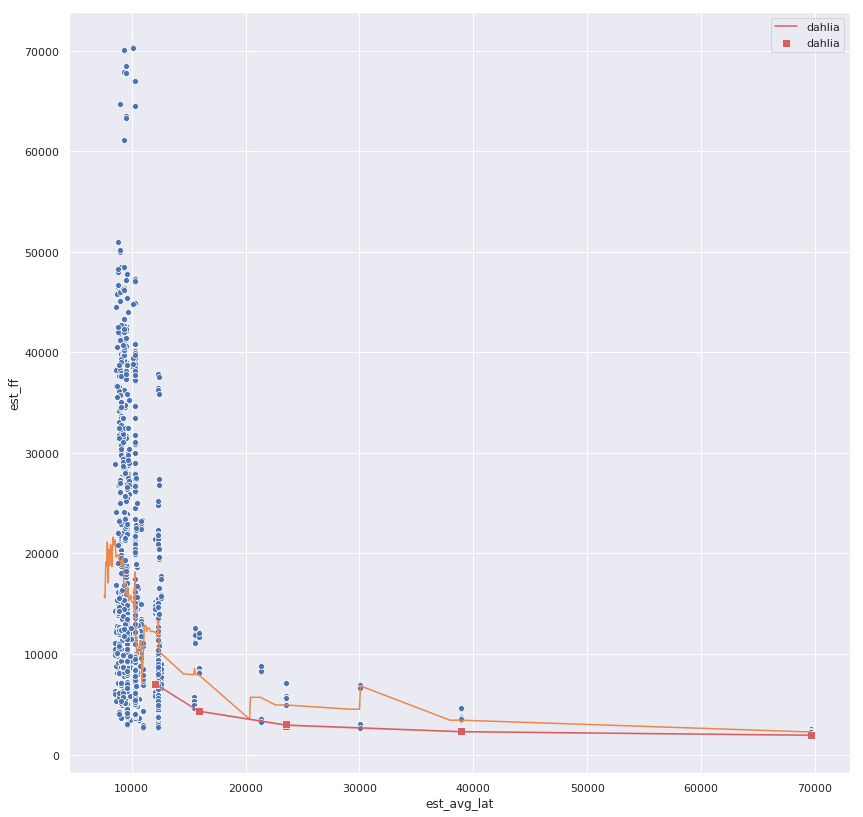

In [153]:
fig = plt.figure(figsize=(14, 14))
def make_buckets(buc_size):
    space_points = int(df.est_avg_lat.max() / buc_size)
    buckets = []
    for idx in range(0, df.est_avg_lat.max(), space_points):
        buckets.append((idx, df[df.est_avg_lat.isin(range(idx, idx + buc_size))]))
    return buckets

pal = sns.color_palette('muted', 8)
# Colors
pareto = pal[1]
dahlia = pal[3]

bs = make_buckets(1000)
for key in ['est_ff']:
    std = list(map(lambda b: b[1][key].std(), bs))
    mean = list(map(lambda b: b[1][key].mean(), bs))
    
    up_std = list(map(lambda b: b[1][key].mean() + b[1][key].std(), bs))
    down_std = list(map(lambda b: b[1][key].mean() - b[1][key].std(), bs))

    sns.scatterplot(x='est_avg_lat', y=key, data=df)
    sns.lineplot(list(map(lambda b: b[0], bs)), mean, color=pareto)
    # sns.lineplot(list(map(lambda b: b[0], bs)), up_std, color=pareto, dashes='--')
    # sns.lineplot(list(map(lambda b: b[0], bs)), down_std, color=pareto, dashes='--')
    sns.lineplot(x='est_avg_lat', y=key, data=dahlia_points, color=dahlia, label='dahlia')
    sns.scatterplot(x='est_avg_lat', y=key, data=dahlia_points, color=dahlia, label='dahlia', marker='s', s=50)
    # sns.lineplot(range(0, len(avg)), avg)


In [6]:
# Set of scatter plots to draw
resources = [ 'est_' + key for key in [ 'ff', 'dsp', 'bram', 'lut' ]]
lat_plots = [ ('est_avg_lat', key) for key in resources ]
lut_plots = [ ('est_lut', key) for key in resources]

In [7]:
# Calculate pareto points
# From: https://stackoverflow.com/questions/32791911/fast-calculation-of-pareto-front-in-python

# If difference between two points is less that LAT_BOUND, then
# don't consider it as "better latency".
LAT_BOUND = 10

def find_pareto(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_efficient[i] = np.all(np.any(costs[:i]>c, axis=1)) and np.all(np.any(costs[i+1:]>c, axis=1))
    return is_efficient

opts = find_pareto(df[['est_avg_lat'] + resources].to_numpy())
opt_idxs = np.where(opts == True)

Text(0.5, 0.05, 'Dot Product DSE - Pareto Optimal Points (Resources & Latency)')

<Figure size 432x288 with 0 Axes>

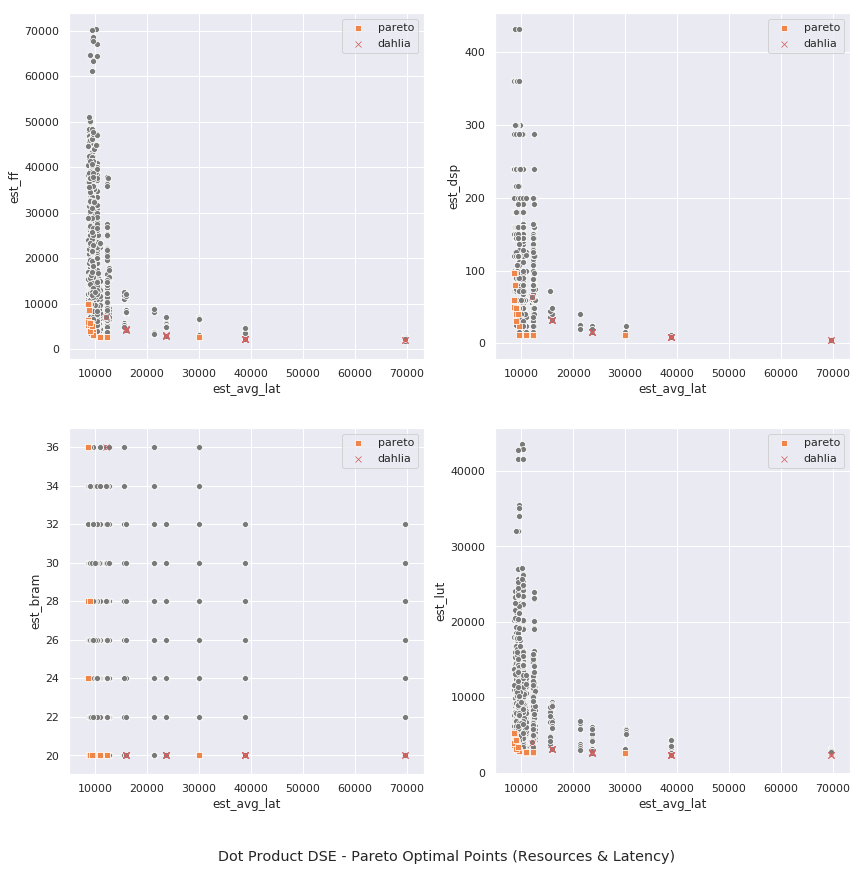

In [8]:
plt.figure()
sns.set()

# Configuration for subplot
cols = 2
rows = int(len(lat_plots) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, 14))
pal = sns.color_palette('muted', 8)
# Colors
pareto = pal[1]
dahlia = pal[3]

for idx, (x_key, y_key) in enumerate(lat_plots):
    ax = axes[int(idx / cols), idx % cols]
    sns.scatterplot(x=x_key, y=y_key, data=df, ax=ax, color=pal[-1])
    
    # plot pareto optimal points
    for idx in opt_idxs:
        sns.scatterplot(x=x_key, y=y_key, data=df.loc[opt_idxs], ax=ax, color=pareto, marker='s', label='pareto')
        
    # plot dahlia points
    sns.scatterplot(x=x_key, y=y_key, data=dahlia_points, ax=ax, color=dahlia, marker='x', label='dahlia')
fig.suptitle('Dot Product DSE - Pareto Optimal Points (Resources & Latency)', y = 0.05)

In [9]:
fig.savefig('pareto-latency.png', dpi=300)

Text(0.5, 0.05, 'Dot Product DSE - Pareto Optimal Points (Resources & Latency)')

<Figure size 432x288 with 0 Axes>

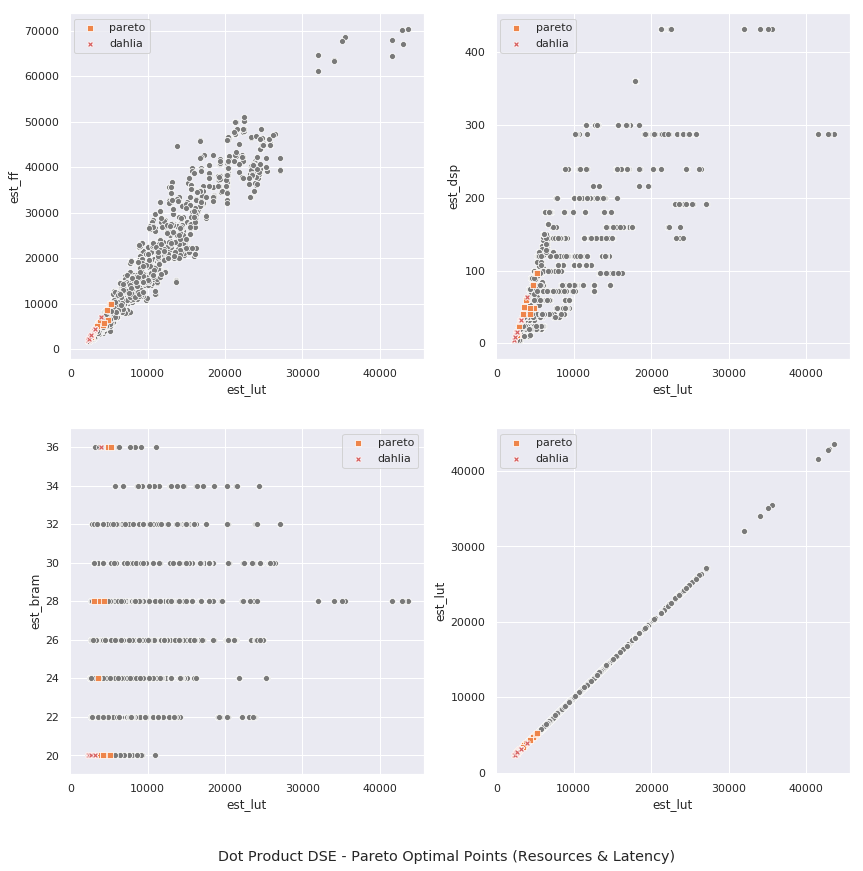

In [10]:
plt.figure()
sns.set()

# Configuration for subplot
cols = 2
rows = int(len(lut_plots) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, 14))

for idx, (x_key, y_key) in enumerate(lut_plots):
    ax = axes[int(idx / cols), idx % cols]
    sns.scatterplot(x=x_key, y=y_key, data=df, ax=ax, color=pal[-1])
    
    # plot pareto optimal points
    for idx in opt_idxs:
        sns.scatterplot(x=x_key, y=y_key, data=df.loc[opt_idxs], ax=ax, color=pareto, marker='s', label='pareto')
        
    # plot dahlia points
    sns.scatterplot(x=x_key, y=y_key, data=dahlia_points, ax=ax, color=dahlia, marker='X', label='dahlia')
fig.suptitle('Dot Product DSE - Pareto Optimal Points (Resources & Latency)', y = 0.05)

In [11]:
fig.savefig('pareto-lut.png', dpi=300)

In [12]:
# Calculate pareto optimal points w/o latency as an optimization function
# Since pareto requires strict >, we have to remove points that have the [resources] counts
no_dup = df.drop_duplicates(subset=resources)
opts = find_pareto(no_dup[resources].to_numpy())
optimal_points = no_dup.iloc[np.where(opts == True)]
count = 0
idxs = []

# Recover the points that have the same [resource counts]
for idx in range(len(df)):
    flag = False
    # print(no_dup.loc[idx][resources])
    for c_idx in range(len(optimal_points)):
        x = df.iloc[idx][resources].equals(optimal_points.iloc[c_idx][resources])
        # print("{} \t {} \t {}".format(no_dup.iloc[idx].bench, optimal_points.iloc[c_idx].bench, x))
        flag = flag or x
    if flag:
        count += 1
        idxs.append(df.iloc[idx].bench)
        print(df.iloc[idx].bench)
print(count)

0-1-0-1-1
0-1-0-1-0
0-0-0-1-0
0-1-0-0-0
0-0-0-1-1
0-1-0-0-1
0-0-0-0-1
0-0-0-0-0
8


Text(0.5, 0.05, 'Dot Product DSE - Pareto Optimal Points (Only Resources)')

<Figure size 432x288 with 0 Axes>

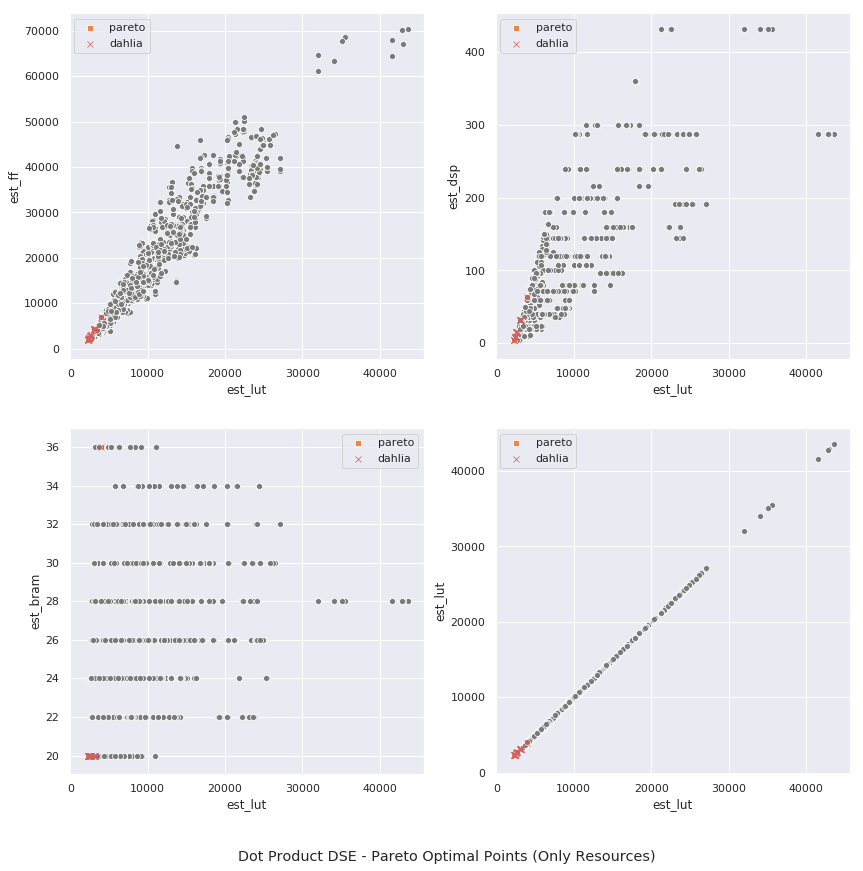

In [13]:
# pareto optimal points for just [resources]
resource_optimal_df = df[df.bench.isin(idxs)]
plt.figure()
sns.set()

# Configuration for subplot
cols = 2
rows = int(len(lut_plots) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, 14))
pal = sns.color_palette('muted', 8)

for idx, (x_key, y_key) in enumerate(lut_plots):
    ax = axes[int(idx / cols), idx % cols]
    sns.scatterplot(x=x_key, y=y_key, data=df, ax=ax, color=pal[-1])
    
    # plot pareto optimal points
    for idx in opt_idxs:
        sns.scatterplot(x=x_key, y=y_key, data=resource_optimal_df, ax=ax, marker='s', color=pareto, label='pareto')
        
    # plot dahlia points
    sns.scatterplot(x=x_key, y=y_key, data=dahlia_points, ax=ax, color=dahlia, marker='x', label='dahlia')
fig.suptitle('Dot Product DSE - Pareto Optimal Points (Only Resources)', y = 0.05)

In [14]:
fig.savefig('pareto-resource-lut.png', dpi=300)

In [15]:
dahlia_points.sort_values(by=['est_avg_lat'])[:10]

,status,est_avg_lat,est_lut,bench,unroll,est_bram,bank2,est_min_lat,est_dsp,resource1,resource2,est_max_lat,est_ff,bank1
635,ok,12044,3921,7-7-11-1-1,16,36,8,12044,64,RAM_T2P_BRAM,RAM_T2P_BRAM,12044,7047,8
4078,ok,15884,3178,7-7-6-0-1,8,20,8,15884,32,RAM_1P_BRAM,RAM_T2P_BRAM,15884,4362,8
85,ok,15884,3096,7-3-6-1-1,8,20,4,15884,32,RAM_T2P_BRAM,RAM_T2P_BRAM,15884,4312,8
3805,ok,15884,3178,7-7-6-1-0,8,20,8,15884,32,RAM_T2P_BRAM,RAM_1P_BRAM,15884,4362,8
3559,ok,15884,3178,7-7-6-1-1,8,20,8,15884,32,RAM_T2P_BRAM,RAM_T2P_BRAM,15884,4362,8
672,ok,15884,3064,3-7-6-1-1,8,20,8,15884,32,RAM_T2P_BRAM,RAM_T2P_BRAM,15884,4237,4
3527,ok,15884,3064,3-7-6-1-0,8,20,8,15884,32,RAM_T2P_BRAM,RAM_1P_BRAM,15884,4237,4
3512,ok,15884,3096,7-3-6-0-1,8,20,4,15884,32,RAM_1P_BRAM,RAM_T2P_BRAM,15884,4312,8
2771,ok,15884,3068,3-3-6-1-1,8,20,4,15884,32,RAM_T2P_BRAM,RAM_T2P_BRAM,15884,4392,4
2321,ok,15884,3178,7-7-6-0-0,8,20,8,15884,32,RAM_1P_BRAM,RAM_1P_BRAM,15884,4362,8


In [18]:
df.iloc[opt_idxs].sort_values(by=['est_avg_lat', 'est_dsp'])

,status,est_avg_lat,est_lut,bench,unroll,est_bram,bank2,est_min_lat,est_dsp,resource1,resource2,est_max_lat,est_ff,bank1
4182,ok,8565,5284,7-7-14-1-1,24,36,8,8565,96,RAM_T2P_BRAM,RAM_T2P_BRAM,8565,9860,8
1314,ok,8567,4921,7-7-9-1-1,12,36,8,8567,48,RAM_T2P_BRAM,RAM_T2P_BRAM,8567,6362,8
3772,ok,8569,3879,5-5-9-1-1,12,28,6,8569,60,RAM_T2P_BRAM,RAM_T2P_BRAM,8569,6024,6
3002,ok,8637,3614,4-4-8-1-1,10,24,5,8637,50,RAM_T2P_BRAM,RAM_T2P_BRAM,8637,5327,5
3459,ok,8736,5162,3-7-14-1-0,24,20,8,8736,96,RAM_T2P_BRAM,RAM_1P_BRAM,8736,9853,4
1581,ok,8839,4740,3-3-13-1-1,20,20,4,8839,80,RAM_T2P_BRAM,RAM_T2P_BRAM,8839,8680,4
857,ok,8906,3754,3-3-9-1-1,12,20,4,8906,48,RAM_T2P_BRAM,RAM_T2P_BRAM,8906,5796,4
4311,ok,8906,4359,3-7-9-1-1,12,28,8,8906,48,RAM_T2P_BRAM,RAM_T2P_BRAM,8906,5685,4
3893,ok,8910,3104,2-2-5-1-1,6,28,3,8910,30,RAM_T2P_BRAM,RAM_T2P_BRAM,8910,4002,3
3479,ok,9043,4287,3-3-8-1-1,10,20,4,9043,40,RAM_T2P_BRAM,RAM_T2P_BRAM,9043,5249,4


In [19]:
resource_optimal_df.sort_values(by='est_avg_lat')

,status,est_avg_lat,est_lut,bench,unroll,est_bram,bank2,est_min_lat,est_dsp,resource1,resource2,est_max_lat,est_ff,bank1
1046,ok,69644,2277,0-1-0-1-1,1,20,2,69644,4,RAM_T2P_BRAM,RAM_T2P_BRAM,69644,1869,1
1523,ok,69644,2277,0-1-0-1-0,1,20,2,69644,4,RAM_T2P_BRAM,RAM_1P_BRAM,69644,1869,1
1717,ok,69644,2268,0-0-0-1-0,1,20,1,69644,4,RAM_T2P_BRAM,RAM_1P_BRAM,69644,1932,1
1809,ok,69644,2277,0-1-0-0-0,1,20,2,69644,4,RAM_1P_BRAM,RAM_1P_BRAM,69644,1869,1
2373,ok,69644,2268,0-0-0-1-1,1,20,1,69644,4,RAM_T2P_BRAM,RAM_T2P_BRAM,69644,1932,1
2599,ok,69644,2277,0-1-0-0-1,1,20,2,69644,4,RAM_1P_BRAM,RAM_T2P_BRAM,69644,1869,1
3405,ok,69644,2268,0-0-0-0-1,1,20,1,69644,4,RAM_1P_BRAM,RAM_T2P_BRAM,69644,1932,1
3958,ok,69644,2268,0-0-0-0-0,1,20,1,69644,4,RAM_1P_BRAM,RAM_1P_BRAM,69644,1932,1


In [20]:
full_synth_df = pd.read_csv('full-synth/summary.csv')
# Cleanup bench names
full_synth_df.bench = full_synth_df.apply(lambda row: row.bench.split(':')[1].replace('dot-product-', ''), axis=1)

In [21]:
pareto_est = df.copy()[df.bench.isin(full_synth_df.bench)]
pareto_est['type'] = 'estimate'
pareto_est = pareto_est.rename(columns={'est_lut': 'lut_used', 'est_bram': 'bram_used', 'est_ff': 'ff_used', 'est_dsp': 'dsp_used'})

In [22]:
resources = [
    'bram_used', 'lut_used', 'dsp_used'
]
full_synth_df['type'] = 'synth'
both_df = full_synth_df[resources + ['bench']].set_index('bench').join(pareto_est[resources + ['bench']].set_index('bench'), lsuffix='_full', rsuffix='_est').reset_index()
for res in resources:
    both_df[res + '_error'] = both_df.apply(lambda row: row[res + '_est'] - row[res + '_full'], axis=1)
both_df = both_df.sort_values(by='bench')

,bench,bram_used_full,lut_used_full,dsp_used_full,bram_used_est,lut_used_est,dsp_used_est,bram_used_error,lut_used_error,dsp_used_error
5,0-0-0-0-0,10,1471,3,20,2268,4,10,797,1
7,2-2-5-1-1,14,1793,24,28,3104,30,14,1311,6
8,3-3-6-1-1,10,1873,24,20,3068,32,10,1195,8
16,3-3-8-1-1,10,2419,30,20,4287,40,10,1868,10
2,3-3-9-1-1,10,2142,36,20,3754,48,10,1612,12
12,3-7-14-1-0,10,2864,72,20,5162,96,10,2298,24
9,3-7-6-1-0,10,1834,24,20,3064,32,10,1230,8
1,3-7-6-1-1,10,1834,24,20,3064,32,10,1230,8
13,3-7-9-1-1,14,2392,36,28,4359,48,14,1967,12
0,4-4-8-1-1,12,2027,40,24,3614,50,12,1587,10


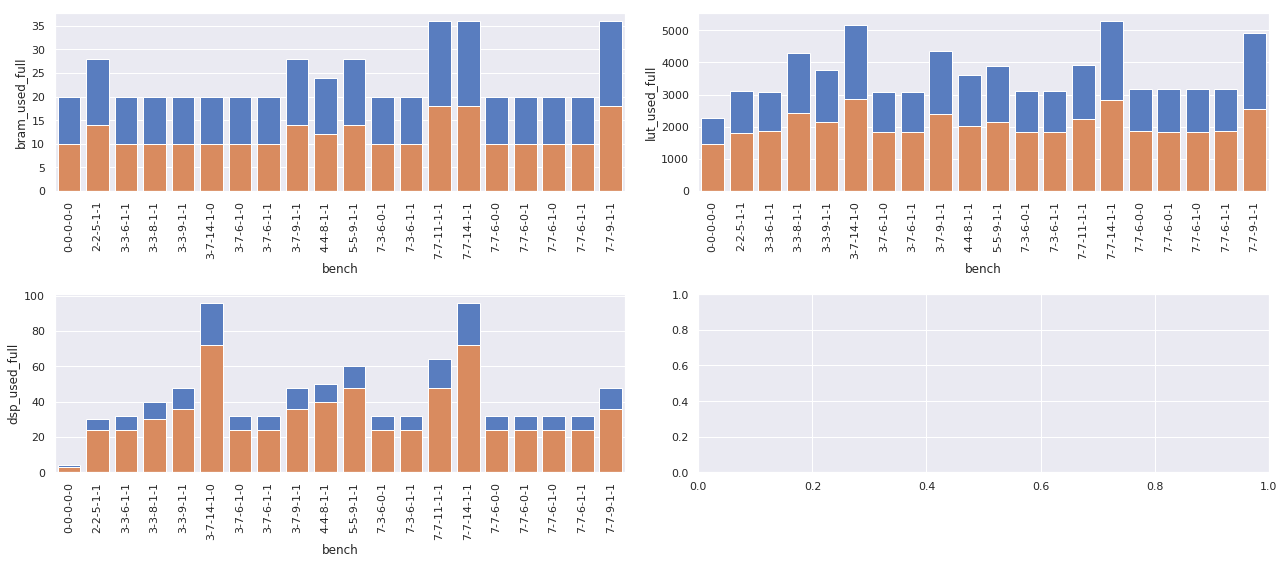

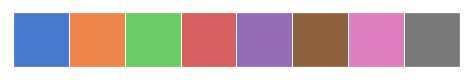

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(18, 8))
sns.palplot(pal)

for idx, res in enumerate(resources):
    ax = axes[int(idx / cols), idx % cols]
    sns.barplot(x='bench', y=res + '_est', data=both_df, ax=ax, color=pal[0], label='estimate')
    sns.barplot(x='bench', y=res + '_full', data=both_df, ax=ax, color=pal[1], label='synthesis')
    ax.tick_params(labelrotation=90, axis='x')

fig.tight_layout()
# print(df[df.bench == '7-7-14-1-1'])
both_df

In [24]:
fig.savefig('estimate-errors.png', dpi=300)

In [25]:
import re
full_synth_df = pd.read_csv('full-synth/summary.csv')
full_synth_df['who'] = full_synth_df.apply(lambda row: 'dahlia' if re.search(r'^dahlia.*', row.bench) else 'orig', axis=1)
full_synth_df.bench = full_synth_df.apply(lambda row: row.bench.split(':')[1].replace('dot-product-', ''), axis=1)
full_synth_df = full_synth_df.sort_values(by='bench')

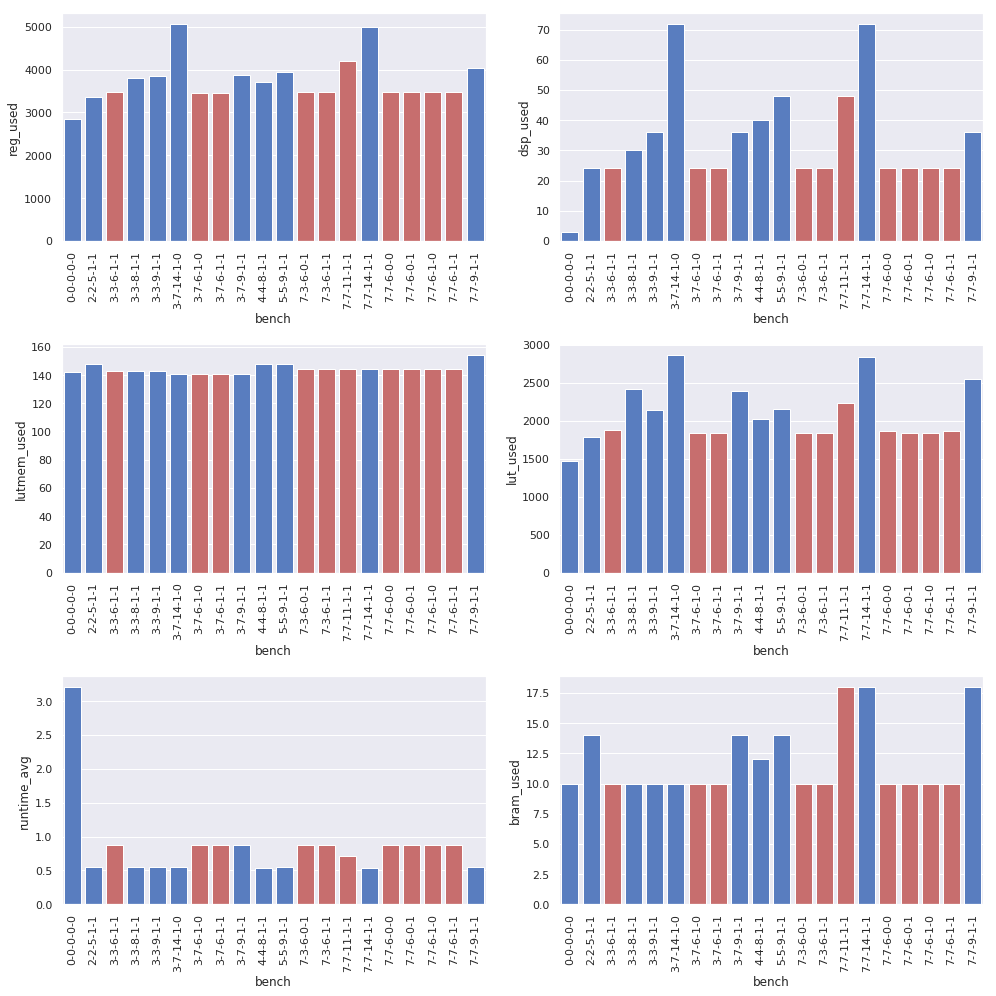

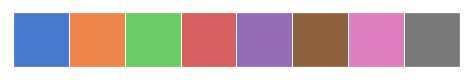

In [26]:
resources = [
    'reg_used', 'dsp_used', 'lutmem_used', 'lut_used', 'runtime_avg', 'bram_used'
]
fig, axes = plt.subplots(3, 2, figsize=(14, 14))
sns.palplot(pal)

for idx, res in enumerate(resources):
    ax = axes[int(idx / cols), idx % cols]
    sns.barplot(x='bench', y=res, data=full_synth_df, ax=ax, palette=[ pal[3] if el == 'dahlia' else pal[0] for el in full_synth_df.who.array ])
    ax.tick_params(labelrotation=90, axis='x')

fig.tight_layout()

/home/rachit/.local/lib/python3.6/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


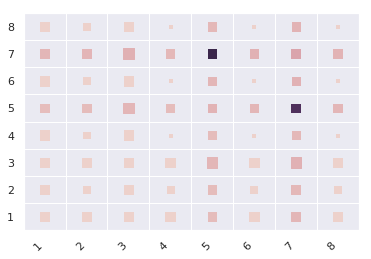

In [27]:
# plt.figure(figsize=(15, 7))
# f = df[df.unroll == 12].sort_values(by='bank1')[['bank1', 'bank2', 'est_min_lat']].drop_duplicates(subset=['bank1', 'bank2']).pivot('bank1', 'bank2', 'est_min_lat')
# sns.heatmap(f, cmap="YlGnBu")

    
n_colors = 256 # Use 256 colors for the diverging color palette
palette = sns.cubehelix_palette(n_colors) # Create the palette
color_min, color_max = [0, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation
# sns.palplot(palette)

def heatmap(x, y, size, color):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    # print(color)
    
    size_scale = size.max()
    color_max = color.max()
    
    def value_to_color(v):
        val = v / color_max
        # val_position = float((val - color_min)) # position of value in the input range, relative to the length of the input range
        ind = int(val ** 4 * (n_colors - 1)) # target index in the color palette
        return palette[ind]

    plt.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size ** 5 * 0.00000000000015 / size_scale, # Vector of square sizes, proportional to size parameter
        c=color.apply(value_to_color),
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])

    

f = df[df.unroll == 12]
heatmap(f.bank1, f.bank2, f.est_min_lat, f.est_lut)

In [28]:
f[f.bank1 == 8][f.bank2 == 8]

/home/rachit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,status,est_avg_lat,est_lut,bench,unroll,est_bram,bank2,est_min_lat,est_dsp,resource1,resource2,est_max_lat,est_ff,bank1
86,ok,8907,4850,7-7-9-0-1,12,28,8,8907,48,RAM_1P_BRAM,RAM_T2P_BRAM,8907,5994,8
1314,ok,8567,4921,7-7-9-1-1,12,36,8,8567,48,RAM_T2P_BRAM,RAM_T2P_BRAM,8567,6362,8
3500,ok,8907,4850,7-7-9-1-0,12,28,8,8907,48,RAM_T2P_BRAM,RAM_1P_BRAM,8907,5994,8
3938,ok,8907,4826,7-7-9-0-0,12,20,8,8907,48,RAM_1P_BRAM,RAM_1P_BRAM,8907,5878,8


In [29]:
f[f.bank1 == 6][f.bank2 == 6]

/home/rachit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,status,est_avg_lat,est_lut,bench,unroll,est_bram,bank2,est_min_lat,est_dsp,resource1,resource2,est_max_lat,est_ff,bank1
1018,ok,8909,3970,5-5-9-1-0,12,28,6,8909,60,RAM_T2P_BRAM,RAM_1P_BRAM,8909,5987,6
1763,ok,8909,3970,5-5-9-0-0,12,28,6,8909,60,RAM_1P_BRAM,RAM_1P_BRAM,8909,5987,6
3413,ok,8909,3970,5-5-9-0-1,12,28,6,8909,60,RAM_1P_BRAM,RAM_T2P_BRAM,8909,5987,6
3772,ok,8569,3879,5-5-9-1-1,12,28,6,8569,60,RAM_T2P_BRAM,RAM_T2P_BRAM,8569,6024,6


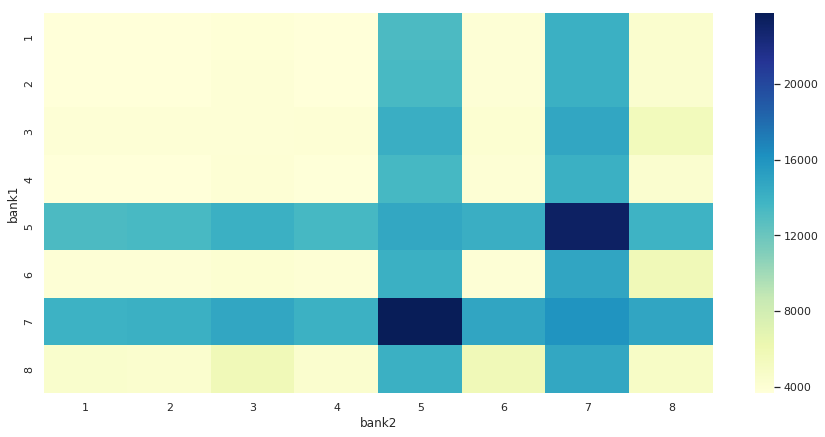

In [30]:
plt.figure(figsize=(15, 7))
g = df[df.unroll == 12].sort_values(by='bank1')[['bank1', 'bank2', 'est_lut']].drop_duplicates(subset=['bank1', 'bank2']).pivot('bank1', 'bank2', 'est_lut')
sns.heatmap(g, cmap="YlGnBu")

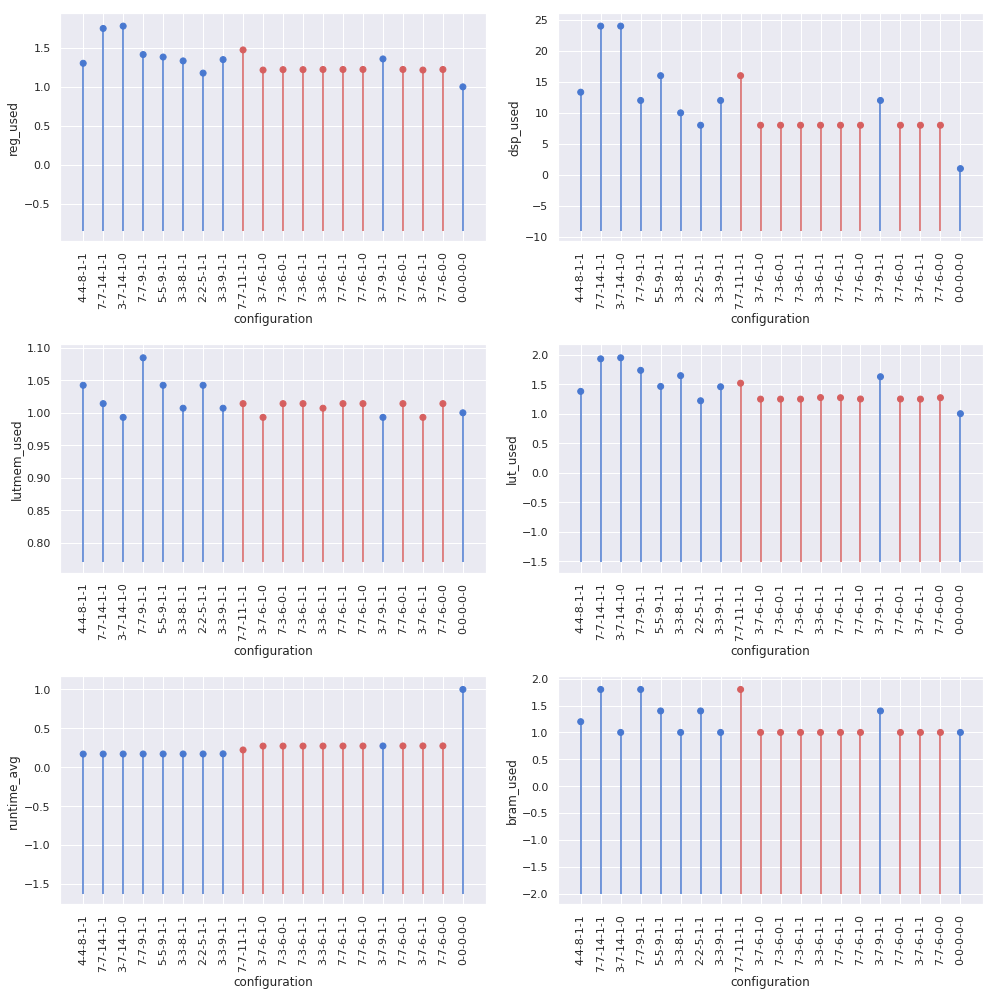

In [31]:
baseline = full_synth_df[full_synth_df.bench == '0-0-0-0-0']

for res in resources:
    full_synth_df[res] = full_synth_df.apply(lambda row: row[res] / baseline[res], axis = 1)
full_synth_df = full_synth_df.sort_values(by='runtime_avg')

fig, axes = plt.subplots(3, 2, figsize=(14, 14))

for idx, res in enumerate(resources):
    # Get current axes for the subplot
    ax = axes[int(idx / cols), idx % cols]
    plt.sca(ax)
  
    color = [ pal[3] if el == 'dahlia' else pal[0] for el in full_synth_df.who.array ]
    ymin = full_synth_df.min()[res] - min(full_synth_df.std()[res] * 10, 10)
    
    plt.vlines(x='bench', ymax=res, data=full_synth_df, ymin=ymin, color=color)
    plt.scatter(x='bench', y=res, data=full_synth_df, color=color)
    ax.tick_params(labelrotation=90, axis='x')
    
    plt.ylabel(res)
    plt.xlabel('configuration')
fig.tight_layout()

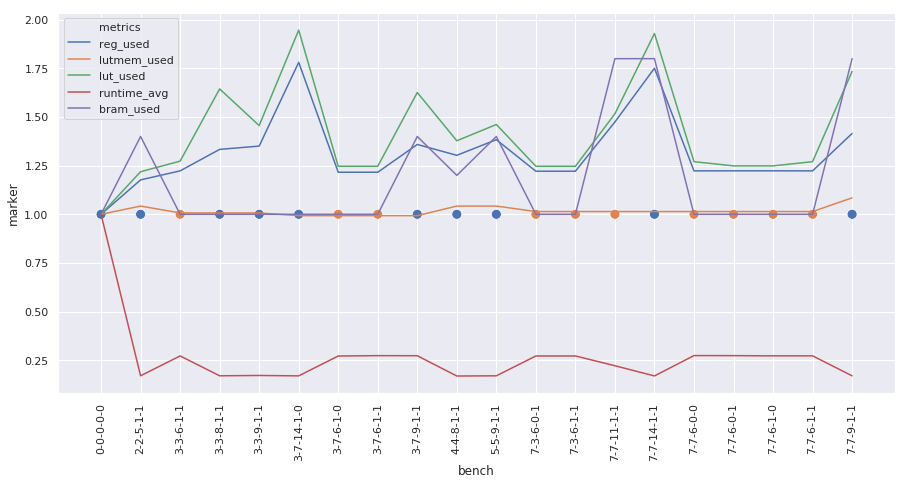

In [32]:
resources = [
    'reg_used', 'lutmem_used', 'lut_used', 'runtime_avg', 'bram_used'
]
plt.figure(figsize=(15, 7))
long = pd.melt(full_synth_df[resources + ['bench']], id_vars=['bench'], var_name='metrics', value_name='values')
plot = sns.lineplot(x='bench', y='values', hue='metrics', data=long)
# plot = sns.scatterplot(x='bench', y='values', hue='metrics', data=long, legend=False, markers=)
full_synth_df['marker'] = 1
plot = sns.scatterplot(x='bench', y='marker', data=full_synth_df, hue='who', s=100, legend=False)
plot.tick_params(labelrotation=90, axis='x')

In [33]:
full_synth_df.sort_values(by=['runtime_avg', 'lut_used'])

,status,reg_used,lut_used,dsp_used,resource1,resource2,unroll,lutmem_used,bench,bank1,bank2,bram_used,uram_used,runtime_avg,runtime_std,who,marker
0,ok,1.303158,1.377974,13.333333,RAM_T2P_BRAM,RAM_T2P_BRAM,10,1.042254,4-4-8-1-1,5,5,1.2,0,0.168682,0.012988,orig,1
3,ok,1.750877,1.929300,24.000000,RAM_T2P_BRAM,RAM_T2P_BRAM,24,1.014085,7-7-14-1-1,8,8,1.8,0,0.169003,0.016055,orig,1
12,ok,1.781053,1.946975,24.000000,RAM_T2P_BRAM,RAM_1P_BRAM,24,0.992958,3-7-14-1-0,4,8,1.0,0,0.169360,0.015170,orig,1
11,ok,1.415439,1.734194,12.000000,RAM_T2P_BRAM,RAM_T2P_BRAM,12,1.084507,7-7-9-1-1,8,8,1.8,0,0.169577,0.013619,orig,1
19,ok,1.383509,1.461591,16.000000,RAM_T2P_BRAM,RAM_T2P_BRAM,12,1.042254,5-5-9-1-1,6,6,1.4,0,0.169671,0.011988,orig,1
16,ok,1.333684,1.644460,10.000000,RAM_T2P_BRAM,RAM_T2P_BRAM,10,1.007042,3-3-8-1-1,4,4,1.0,0,0.169760,0.011725,orig,1
7,ok,1.176842,1.218899,8.000000,RAM_T2P_BRAM,RAM_T2P_BRAM,6,1.042254,2-2-5-1-1,3,3,1.4,0,0.169823,0.016440,orig,1
2,ok,1.350526,1.456152,12.000000,RAM_T2P_BRAM,RAM_T2P_BRAM,12,1.007042,3-3-9-1-1,4,4,1.0,0,0.171413,0.014402,orig,1
18,ok,1.474737,1.516655,16.000000,RAM_T2P_BRAM,RAM_T2P_BRAM,16,1.014085,7-7-11-1-1,8,8,1.8,0,0.221486,0.011966,dahlia,1
9,ok,1.216140,1.246771,8.000000,RAM_T2P_BRAM,RAM_1P_BRAM,8,0.992958,3-7-6-1-0,4,8,1.0,0,0.271523,0.012526,dahlia,1


In [47]:
idxs = df.apply(lambda row: row.est_dsp / row.unroll == 4 and row.resource1 == 'RAM_T2P_BRAM' and row.resource2 == 'RAM_T2P_BRAM', axis = 1 )
df[idxs][df.unroll.isin([12,16])].sort_values(by=['unroll', 'bank1', 'bank2'])[['bench', 'unroll', 'bank1', 'bank2', 'est_dsp', 'est_lut', 'est_avg_lat']]

/home/rachit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,bench,unroll,bank1,bank2,est_dsp,est_lut,est_avg_lat
2882,0-0-9-1-1,12,1,1,48,3666,10272
2902,0-1-9-1-1,12,1,2,48,3645,10272
3998,0-3-9-1-1,12,1,4,48,3669,10272
1891,0-7-9-1-1,12,1,8,48,4374,10272
3670,1-0-9-1-1,12,2,1,48,3681,10272
3875,1-1-9-1-1,12,2,2,48,3689,9248
372,1-3-9-1-1,12,2,4,48,3681,9248
683,1-7-9-1-1,12,2,8,48,4346,9248
1598,3-0-9-1-1,12,4,1,48,3705,10272
2929,3-1-9-1-1,12,4,2,48,3681,9248


In [35]:
8569

8569